# **Setup**

In [ ]:
#!wget https://files.consumerfinance.gov/hmda-historic-loan-data/hmda_2014_nationwide_all-records_labels.zip

In [ ]:
#!unzip hmda_2014_nationwide_all-records_labels.zip

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%ls

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
import numpy as np
import math
from pyspark.sql.functions import explode, col, concat
from pyspark.sql.functions import when
import itertools
from pyspark.sql.functions import col, avg
from pyspark.sql import functions as F
from pyspark.sql.functions import col , column

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# **View & Preprocess data**

In [ ]:
###### Most of these columns are empty; so, they do not really add new info -> drop them
#df_records = pd.read_csv('gdrive/MyDrive/Big Data Projects/Final Project/data.csv',index_col= 'respondent_id')
#df_records= df_records.drop(['as_of_year','applicant_race_name_2','applicant_race_2','applicant_race_name_3',
#                             'applicant_race_3','applicant_race_name_4','applicant_race_4',
#                             'applicant_race_name_5','applicant_race_5',
#                             'co_applicant_race_name_2','co_applicant_race_2','co_applicant_race_name_3',
#                             'co_applicant_race_3','co_applicant_race_name_4','co_applicant_race_3',
#                             'co_applicant_race_name_4','co_applicant_race_4', 'co_applicant_race_name_5',
#                             'co_applicant_race_5'], axis=1)
#df_records.to_csv('gdrive/MyDrive/Big Data Projects/Final Project/data_useful.csv')
# ---------------> columns dropped and data saved in data_useful.csv
###### 90% of these columns were empty
#df_records = pd.read_csv('gdrive/MyDrive/Big Data Projects/Final Project/data_useful.csv')
#df_records = df_records.drop(['edit_status_name','edit_status',
#                              'denial_reason_name_1','denial_reason_1',
#                              'denial_reason_name_2','denial_reason_2',
#                              'denial_reason_name_3','denial_reason_3','rate_spread'],axis=1)
#df_records_cleaned = df_records.dropna()
#df_records_cleaned.to_csv('gdrive/MyDrive/Big Data Projects/Final Project/data_useful_updated.csv')
# ---------------> columns dropped and data saved in data_useful_updated.csv

## < I kept them in different files in case we needed them for insights > ##

In [ ]:
df_records = pd.read_csv('gdrive/MyDrive/Final Project/data_useful_updated.csv',index_col=False)

In [ ]:
#df_records = df_records.loc[:, ~df_records.columns.str.contains('^Unnamed')]
df_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769112 entries, 0 to 6769111
Data columns (total 53 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   respondent_id                   object 
 2   agency_name                     object 
 3   agency_abbr                     object 
 4   agency_code                     int64  
 5   loan_type_name                  object 
 6   loan_type                       int64  
 7   property_type_name              object 
 8   property_type                   int64  
 9   loan_purpose_name               object 
 10  loan_purpose                    int64  
 11  owner_occupancy_name            object 
 12  owner_occupancy                 int64  
 13  loan_amount_000s                int64  
 14  preapproval_name                object 
 15  preapproval                     int64  
 16  action_taken_name               object 
 17  action_taken               

In [ ]:
df_records.describe()

,Unnamed: 0,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,msamd,state_code,county_code,census_tract_number,applicant_ethnicity,co_applicant_ethnicity,applicant_race_1,co_applicant_race_1,applicant_sex,co_applicant_sex,applicant_income_000s,purchaser_type,hoepa_status,lien_status,sequence_number,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,application_date_indicator
count,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06,6.769112e+06
mean,4.484828e+06,6.852959e+00,1.334821e+00,1.024278e+00,1.934738e+00,1.105274e+00,2.144966e+02,2.820834e+00,2.247986e+00,2.988989e+04,2.638624e+01,8.558126e+01,1.869701e+03,2.047178e+00,3.680611e+00,4.811376e+00,6.596224e+00,1.476955e+00,3.622999e+00,1.070841e+02,1.704574e+00,1.999901e+00,1.341963e+00,9.754802e+04,5.545651e+03,3.324337e+01,6.896524e+04,1.167088e+02,1.444350e+03,1.860066e+03,1.603265e-01
std,2.567154e+06,2.294285e+00,6.849888e-01,1.539103e-01,9.587845e-01,3.085576e-01,2.274823e+02,4.497749e-01,1.642653e+00,1.134568e+04,1.695822e+01,1.042206e+02,2.782036e+03,5.488484e-01,1.497916e+00,1.039896e+00,1.682329e+00,7.218676e-01,1.566077e+00,1.561728e+02,2.543298e+00,9.955748e-03,8.795573e-01,2.057132e+05,2.876305e+03,2.588485e+01,1.397332e+04,4.258784e+01,7.649985e+02,9.338463e+02,5.430899e-01
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.018000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,3.400000e-01,1.750000e+04,6.350000e+00,2.000000e+00,1.000000e+00,0.000000e+00
25%,2.267693e+06,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+02,3.000000e+00,1.000000e+00,1.912400e+04,9.000000e+00,2.700000e+01,1.010500e+02,2.000000e+00,2.000000e+00,5.000000e+00,5.000000e+00,1.000000e+00,2.000000e+00,4.900000e+01,0.000000e+00,2.000000e+00,1.000000e+00,1.808000e+03,3.812000e+03,1.267000e+01,6.060000e+04,8.878000e+01,9.410000e+02,1.270000e+03,0.000000e+00
50%,4.500522e+06,7.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.670000e+02,3.000000e+00,1.000000e+00,3.108400e+04,2.500000e+01,6.100000e+01,3.150200e+02,2.000000e+00,5.000000e+00,5.000000e+00,8.000000e+00,1.000000e+00,5.000000e+00,7.700000e+01,0.000000e+00,2.000000e+00,1.000000e+00,1.224100e+04,5.072000e+03,2.534000e+01,6.800000e+04,1.106700e+02,1.336000e+03,1.717000e+03,0.000000e+00
75%,6.671482e+06,9.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,2.700000e+02,3.000000e+00,3.000000e+00,4.014000e+04,4.100000e+01,1.070000e+02,2.523020e+03,2.000000e+00,5.000000e+00,5.000000e+00,8.000000e+00,2.000000e+00,5.000000e+00,1.220000e+02,2.000000e+00,2.000000e+00,1.000000e+00,8.149425e+04,6.579000e+03,4.769000e+01,7.540000e+04,1.375900e+02,1.802000e+03,2.276000e+03,0.000000e+00
max,8.999999e+06,9.000000e+00,4.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,9.999900e+04,3.000000e+00,8.000000e+00,4.974000e+04,7.200000e+01,8.400000e+02,9.856000e+03,4.000000e+00,5.000000e+00,7.000000e+00,8.000000e+00,4.000000e+00,5.000000e+00,9.999000e+03,9.000000e+00,2.000000e+00,4.000000e+00,1.118443e+06,3.745200e+04,1.000000e+02,1.113000e+05,4.993500e+02,8.526000e+03,1.322700e+04,2.000000e+00


In [ ]:
#df_records.isnull().sum() ##All is well
df_records.head(2)

,Unnamed: 0,respondent_id,agency_name,agency_abbr,agency_code,loan_type_name,loan_type,property_type_name,property_type,loan_purpose_name,loan_purpose,owner_occupancy_name,owner_occupancy,loan_amount_000s,preapproval_name,preapproval,action_taken_name,action_taken,msamd_name,msamd,state_name,state_abbr,state_code,county_name,county_code,census_tract_number,applicant_ethnicity_name,applicant_ethnicity,co_applicant_ethnicity_name,co_applicant_ethnicity,applicant_race_name_1,applicant_race_1,co_applicant_race_name_1,co_applicant_race_1,applicant_sex_name,applicant_sex,co_applicant_sex_name,co_applicant_sex,applicant_income_000s,purchaser_type_name,purchaser_type,hoepa_status_name,hoepa_status,lien_status_name,lien_status,sequence_number,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,application_date_indicator
0,0,0000019506,Federal Deposit Insurance Corporation,FDIC,3,Conventional,1,One-to-four family dwelling (other than manufa...,1,Home purchase,1,Not owner-occupied as a principal dwelling,2,81,Preapproval was not requested,2,Loan originated,1,"Carbondale, Marion - IL",16060.0,Illinois,IL,17.0,Jackson County,77.0,111.00,Not Hispanic or Latino,2,Not Hispanic or Latino,2,White,5,White,5,Male,1,Female,2,167.0,Fannie Mae (FNMA),1,Not a HOEPA loan,2,Secured by a first lien,1,324,3177.0,28.77,54000.0,61.650002,160.0,773.0,0
1,1,0000476810,Consumer Financial Protection Bureau,CFPB,9,Conventional,1,One-to-four family dwelling (other than manufa...,1,Refinancing,3,Owner-occupied as a principal dwelling,1,58,Not applicable,3,Loan originated,1,Macon - GA,31420.0,Georgia,GA,13.0,Bibb County,21.0,134.09,Not Hispanic or Latino,2,No co-applicant,5,White,5,No co-applicant,8,Female,2,No co-applicant,5,15.0,Affiliate institution,8,Not a HOEPA loan,2,Secured by a first lien,1,45374,4143.0,33.48,49800.0,148.050003,1110.0,1352.0,0


In [ ]:
#The actions will be modified before the ML model
df_records['action_taken_name'].value_counts()#(normalize=True).plot.bar(figsize=(5,5), title='Actions Taken')

Loan originated                                        3822430
Application denied by financial institution            1227255
Application withdrawn by applicant                      683344
Loan purchased by the institution                       542628
Application approved but not accepted                   248320
File closed for incompleteness                          244594
Preapproval request denied by financial institution        410
Preapproval request approved but not accepted              131
Name: action_taken_name, dtype: int64

#**Data Analysis**

##What we will find:
- The relation between the loan approval and the ethnicity,race and gender of the applicant. -> **Done**
- The relation between the loan approval and the location of the applicant (the county, state, and msamd). -> **Done**
- The relation between the loan approval and the purpose of the loan (purposes are mentioned above). -> **Done**
- The relation between the loan approval and the agency that the financial institution is a part of. -> **Done**
- Pre-approval application effect on the acceptance. -> **Done**
- The relation between the location, the total population and the minority population and the loan approval. -> **Done**

### **Ethnicity**

In [ ]:
file_path = 'gdrive/MyDrive/Final Project/data_useful_updated.csv'

In [ ]:
rawData= spark.read.format("csv").option("header", "true").load(file_path)

In [ ]:
total_rows = rawData.count()

In [ ]:
total_rows

6769112

In [ ]:
purCount = rawData.groupBy('purchaser_type_name').count().orderBy(['count'], ascending = False)
purCount.show()

In [ ]:
#rawData.printSchema()

In [ ]:
er = "Information not provided by applicant in mail, Internet, or telephone application"
parDF = rawData.select(col("respondent_id").alias("finID"),col("sequence_number").alias("loanID"), #loan identifiers
                     col("applicant_ethnicity_name").alias("eth_appl"),col("co_applicant_ethnicity_name").alias("co_eth_appl"), #ethnicity
                     col("applicant_race_name_1").alias("race_applicant"),col("co_applicant_race_name_1").alias("co_race_applicant"), #race
                     col("applicant_sex_name").alias("gen_applicant"),col("co_applicant_sex_name").alias("co_gen_applicant") #gender
                     ,col("action_taken_name").alias("action"), col("applicant_income_000s").alias("income"),
                     col("loan_amount_000s").alias("amount"))
#modify ethnicity values
parDF = parDF.withColumn("eth_appl", F.when(F.col("eth_appl")== er,"NotAvailable").otherwise(F.col("eth_appl")))\
              .withColumn("eth_appl", F.when(F.col("eth_appl")== "Not applicable","NotAvailable").otherwise(F.col("eth_appl")))\
              .withColumn("co_eth_appl", F.when(F.col("co_eth_appl")== er,"NotAvailable").otherwise(F.col("co_eth_appl")))\
              .withColumn("co_eth_appl", F.when(F.col("co_eth_appl")== "Not applicable","NotAvailable").otherwise(F.col("co_eth_appl")))\
              .withColumn("co_eth_appl", F.when(F.col("co_eth_appl")== "No co-applicant","NotAvailable").otherwise(F.col("co_eth_appl")))
#modify race values
parDF = parDF.withColumn("race_applicant", F.when(F.col("race_applicant")== er,"NotAvailable").otherwise(F.col("race_applicant")))\
              .withColumn("race_applicant", F.when(F.col("race_applicant")== "Not applicable","NotAvailable").otherwise(F.col("race_applicant")))\
              .withColumn("co_race_applicant", F.when(F.col("co_race_applicant")== er,"NotAvailable").otherwise(F.col("co_race_applicant")))\
              .withColumn("co_race_applicant", F.when(F.col("co_race_applicant")== "Not applicable","NotAvailable").otherwise(F.col("co_race_applicant")))\
              .withColumn("co_race_applicant", F.when(F.col("co_race_applicant")== "No co-applicant","NotAvailable").otherwise(F.col("co_race_applicant")))
#modify gender values
parDF = parDF.withColumn("gen_applicant", F.when(F.col("gen_applicant")== er,"NotAvailable").otherwise(F.col("gen_applicant")))\
              .withColumn("gen_applicant", F.when(F.col("gen_applicant")== "Not applicable","NotAvailable").otherwise(F.col("gen_applicant")))\
              .withColumn("co_gen_applicant", F.when(F.col("co_gen_applicant")== er,"NotAvailable").otherwise(F.col("co_gen_applicant")))\
              .withColumn("co_gen_applicant", F.when(F.col("co_gen_applicant")== "Not applicable","NotAvailable").otherwise(F.col("co_gen_applicant")))\
              .withColumn("co_gen_applicant", F.when(F.col("co_gen_applicant")== "No co-applicant","NotAvailable").otherwise(F.col("co_gen_applicant")))

parDF.show(5)

In [ ]:
def sortAlph (x):
  str1 = str(x[0]).lower().split()[0]
  str2 = str(x[1]).lower().split()[0]
  my_str = str1+'<t>'+str2
  words = [word for word in my_str.split('<t>')]
  words.sort()
  if words[0] in str1:
    ind_1 = x[0]
    ind_2 = x[1]
  else:
    ind_1 = x[1]
    ind_2 = x[0]
  return (ind_1, ind_2)

In [ ]:
x = ('Not applicable','Not Hispano or latino',)
sortAlph (x)

('Not applicable', 'Not Hispano or latino')

In [ ]:
#Percentage of each ethnicity
#ethTotalCounts = parDF.rdd.map(lambda x: (x[2],x[3])).map(lambda x: sortAlph(x)) \
#                    .map(lambda x: ((x[0],x[1]),1)) \
#                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0][0],x[0][1],round((x[1]/total_rows)*100,2))) \
#                    .toDF(['Ethnicity_1', 'Ethnicity_2', 'percentage of Ethnicity']) \
#                    .orderBy(['percentage of Ethnicity'], ascending = False)
ethTotalCounts = parDF.rdd.map(lambda x: (x[2],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_rows)*100,2))) \
                    .toDF(['Applicant''s Ethnicity', 'percentage of Ethnicity']) \
                    .orderBy(['percentage of Ethnicity'], ascending = False)
ethTotalCounts.show()

+--------------------+-----------------------+
|Applicants Ethnicity|percentage of Ethnicity|
+--------------------+-----------------------+
|Not Hispanic or L...|                  76.94|
|        NotAvailable|                  12.67|
|  Hispanic or Latino|                  10.38|
+--------------------+-----------------------+



In [ ]:
approvedDF = parDF.rdd.filter(lambda x: x[8]=='Loan originated' or x[8]=='Loan purchased by the institution')
total_approved = approvedDF.toDF().count()

In [ ]:
rejectedDF = parDF.rdd.filter(lambda x: x[8]!='Loan originated' and x[8]!='File closed for incompleteness' and 
                              x[8]!='Application withdrawn by applicant' and x[8]!='Loan purchased by the institution')
total_rejected = rejectedDF.toDF().count()

In [ ]:
#Ethnicity
#ethCounts = approvedDF.map(lambda x: (x[2],x[3])).map(lambda x: sortAlph(x)) \
#                    .map(lambda x: ((x[0],x[1]),1)) \
#                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0][0],x[0][1],round((x[1]/total_approved)*100,2))) \
#                    .toDF(['Ethnicity_1', 'Ethnicity_2', 'percentage of approval']) \
#                    .orderBy(['percentage of approval'], ascending = False)

ethCounts = approvedDF.map(lambda x: (x[2],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Applicant''s Ethnicity', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
ethCounts.show()

+--------------------+----------------------+
|Applicants Ethnicity|percentage of approval|
+--------------------+----------------------+
|Not Hispanic or L...|                 78.45|
|        NotAvailable|                 12.18|
|  Hispanic or Latino|                  9.38|
+--------------------+----------------------+



In [ ]:
#Rejected Ethnicity
#ethCounts_rej = rejectedDF.map(lambda x: (x[2],x[3])).map(lambda x: sortAlph(x)) \
#                    .map(lambda x: ((x[0],x[1]),1)) \
#                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0][0],x[0][1],round((x[1]/total_rejected)*100,2))) \
#                    .toDF(['Ethnicity_1', 'Ethnicity_2', 'percentage of Rejection']) \
#                    .orderBy(['percentage of Rejection'], ascending = False)
ethCounts_rej = rejectedDF.map(lambda x: (x[2],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_rejected)*100,2))) \
                    .toDF(['Applicant''s Ethnicity', 'percentage of Rejection']) \
                    .orderBy(['percentage of Rejection'], ascending = False)
ethCounts_rej.show()

+--------------------+-----------------------+
|Applicants Ethnicity|percentage of Rejection|
+--------------------+-----------------------+
|Not Hispanic or L...|                  73.61|
|        NotAvailable|                   13.5|
|  Hispanic or Latino|                  12.89|
+--------------------+-----------------------+



### **Race**

In [ ]:
#Race
#raceCounts = approvedDF.map(lambda x: (x[4],x[5])).map(lambda x: sortAlph(x)) \
#                    .map(lambda x: ((x[0],x[1]),1)) \
#                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0][0],x[0][1],round((x[1]/total_approved)*100,2))) \
#                    .toDF(['Race_1', 'Race_2', 'percentage of approval']) \
#                    .orderBy(['percentage of approval'], ascending = False)

raceCounts = approvedDF.map(lambda x: (x[4],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Applicant''s Race', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
raceCounts.show()

+--------------------+----------------------+
|     Applicants Race|percentage of approval|
+--------------------+----------------------+
|               White|                 75.25|
|        NotAvailable|                 12.54|
|               Asian|                  5.66|
|Black or African ...|                  5.58|
|American Indian o...|                  0.59|
|Native Hawaiian o...|                  0.38|
+--------------------+----------------------+



In [ ]:
#Race
#raceCounts_rej = rejectedDF.map(lambda x: (x[4],x[5])).map(lambda x: sortAlph(x)) \
#                    .map(lambda x: ((x[0],x[1]),1)) \
#                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0][0],x[0][1],round((x[1]/total_rejected)*100,2))) \
#                    .toDF(['Race_1', 'Race_2', 'percentage of Rejection']) \
#                   .orderBy(['percentage of Rejection'], ascending = False)

raceCounts_rej = rejectedDF.map(lambda x: (x[4],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_rejected)*100,2))) \
                    .toDF(['Applicant''s Race', 'percentage of Rejection']) \
                    .orderBy(['percentage of Rejection'], ascending = False)
raceCounts_rej.show()

+--------------------+-----------------------+
|     Applicants Race|percentage of Rejection|
+--------------------+-----------------------+
|               White|                  67.63|
|        NotAvailable|                  14.05|
|Black or African ...|                  11.44|
|               Asian|                   5.26|
|American Indian o...|                   1.09|
|Native Hawaiian o...|                   0.54|
+--------------------+-----------------------+



In [ ]:
#Relation between 
#(approval/denial, race) and (average loan amount, average income, percenteage of approval/denial)
raceRela = parDF.rdd.map(lambda x: ((x[8],x[4]),(float(x[10]),float(x[9]),1))) \
                    .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2]))\
                    .map(lambda x: (x[0][0],x[0][1], round(x[1][0]/x[1][2],2), round(x[1][1]/x[1][2],2), x[1][2])) \
                    .toDF(['Action','Race of Applicant','Average Loan Amount','Average Income','Count of Action']) \
                    .orderBy(['Count of Action'], ascending = False)
raceRela.show()

+--------------------+--------------------+-------------------+--------------+---------------+
|              Action|   Race of Applicant|Average Loan Amount|Average Income|Count of Action|
+--------------------+--------------------+-------------------+--------------+---------------+
|     Loan originated|               White|             217.36|        112.05|        2978797|
|Application denie...|               White|             180.77|         90.03|         819612|
|Application withd...|               White|             225.49|        112.96|         488952|
|     Loan originated|        NotAvailable|              253.6|        131.23|         361822|
|Loan purchased by...|               White|              203.2|         88.11|         305746|
|     Loan originated|               Asian|             319.21|        136.77|         228488|
|     Loan originated|Black or African ...|             173.69|         81.36|         215672|
|Loan purchased by...|        NotAvailable|       

In [ ]:
raceRela[raceRela['Action']=="Loan originated"].show()

+---------------+--------------------+-------------------+--------------+---------------+
|         Action|   Race of Applicant|Average Loan Amount|Average Income|Count of Action|
+---------------+--------------------+-------------------+--------------+---------------+
|Loan originated|               White|             217.36|        112.05|        2978797|
|Loan originated|        NotAvailable|              253.6|        131.23|         361822|
|Loan originated|               Asian|             319.21|        136.77|         228488|
|Loan originated|Black or African ...|             173.69|         81.36|         215672|
|Loan originated|American Indian o...|             182.63|         91.76|          22834|
|Loan originated|Native Hawaiian o...|             233.76|        102.64|          14817|
+---------------+--------------------+-------------------+--------------+---------------+



### **Gender**

In [ ]:
#gender
#genderCounts = approvedDF.map(lambda x: (x[6],x[7])).map(lambda x: sortAlph(x)) \
#                    .map(lambda x: ((x[0],x[1]),1)) \
#                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0][0],x[0][1],round((x[1]/total_approved)*100,2))) \
#                    .toDF(['Gender_1', 'Gender_2', 'percentage of approval']) \
#                    .orderBy(['percentage of approval'], ascending = False)

genderCounts = approvedDF.map(lambda x: (x[6],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Applicant''s Gender', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
genderCounts.show()

+-----------------+----------------------+
|Applicants Gender|percentage of approval|
+-----------------+----------------------+
|             Male|                 64.31|
|           Female|                 26.82|
|     NotAvailable|                  8.87|
+-----------------+----------------------+



In [ ]:
genderCounts_rej = rejectedDF.map(lambda x: (x[6],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_rejected)*100,2))) \
                    .toDF(['Applicant''s Gender', 'percentage of Rejection']) \
                    .orderBy(['percentage of Rejection'], ascending = False)
genderCounts_rej.show()

+-----------------+-----------------------+
|Applicants Gender|percentage of Rejection|
+-----------------+-----------------------+
|             Male|                  60.71|
|           Female|                  31.06|
|     NotAvailable|                   8.24|
+-----------------+-----------------------+



In [ ]:
#(approval/denial, gender) and (average loan amount, average income, percenteage of approval/denial)
genRela = parDF.rdd.map(lambda x: ((x[8],x[6]),(float(x[10]),float(x[9]),1))) \
                    .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2]))\
                    .map(lambda x: (x[0][0],x[0][1], round(x[1][0]/x[1][2],2), round(x[1][1]/x[1][2],2), x[1][2])) \
                    .toDF(['Action','Gender of Applicant','Average Loan Amount','Average Income','Count of Action']) \
                    .orderBy(['Count of Action'], ascending = False)
genRela.show()

+--------------------+-------------------+-------------------+--------------+---------------+
|              Action|Gender of Applicant|Average Loan Amount|Average Income|Count of Action|
+--------------------+-------------------+-------------------+--------------+---------------+
|     Loan originated|               Male|             237.17|        122.23|        2547191|
|     Loan originated|             Female|              187.3|         87.62|        1061197|
|Application denie...|               Male|             197.16|         97.33|         736858|
|Application withd...|               Male|             243.39|        122.18|         439228|
|Application denie...|             Female|              142.9|         69.75|         386161|
|Loan purchased by...|               Male|             217.23|         94.43|         260036|
|     Loan originated|       NotAvailable|             253.95|        137.12|         214042|
|Application withd...|             Female|             193.1

#### **Average Income for each gender**

In [ ]:
incomeGender = parDF.rdd.map(lambda x: (x[6],(float(x[9]),1))).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).map(lambda x: (x[0], round(x[1][0]/x[1][1],2))) \
                    .toDF(['Applicant''s Gendr', 'Average Income']) \
                    .orderBy(['Average Income'], ascending = False)
incomeGender.show()

+----------------+--------------+
|Applicants Gendr|Average Income|
+----------------+--------------+
|    NotAvailable|        118.74|
|            Male|        116.06|
|          Female|         82.95|
+----------------+--------------+



### **Location Relations**

In [ ]:
parDF_2 = rawData.select(col("respondent_id").alias("finID"),col("state_name").alias("state"),
                     col("msamd_name").alias("msamd"),
                     col("county_name").alias("county"),col("population").alias("population"),
                     col("minority_population").alias("minority"),
                     col("action_taken_name").alias("action"), col("loan_purpose_name").alias("purpose"),
                     col("agency_name").alias("agency"),col("preapproval_name").alias("preapproval"),
                     col("loan_type_name").alias("loan_type"),col("applicant_income_000s").alias("income"),
                    col("loan_amount_000s").alias("loan_amount"),col("hoepa_status_name").alias("hoepa"),
                    col("lien_status_name").alias("lien"),col("owner_occupancy_name").alias("occupancy"),
                    col("property_type_name").alias("property_type"),col("hud_median_family_income").alias("family_income"))
parDF_2.show(5)

+----------+----------+--------------------+----------------+----------+------------------+--------------------+----------------+--------------------+--------------------+------------+------+-----------+----------------+--------------------+--------------------+--------------------+-------------+
|     finID|     state|               msamd|          county|population|          minority|              action|         purpose|              agency|         preapproval|   loan_type|income|loan_amount|           hoepa|                lien|           occupancy|       property_type|family_income|
+----------+----------+--------------------+----------------+----------+------------------+--------------------+----------------+--------------------+--------------------+------------+------+-----------+----------------+--------------------+--------------------+--------------------+-------------+
|0000019506|  Illinois|Carbondale, Mario...|  Jackson County|    3177.0|28.770000457763672|     Loan origi

In [ ]:
approvedDF = parDF_2.rdd.filter(lambda x: x[6]=='Loan originated' or x[6]=='Loan purchased by the institution')
total_approved = approvedDF.toDF().count()

In [ ]:
rejectedDF_2 = parDF_2.rdd.filter(lambda x: x[6]!='Loan originated' and x[6]!='File closed for incompleteness' and 
                              x[6]!='Application withdrawn by applicant' and x[6]!='Loan purchased by the institution')
total_rejected_2 = rejectedDF_2.toDF().count()

In [ ]:
rejectedDF_2.toDF().show()

+----------+--------------+--------------------+--------------------+----------+------------------+--------------------+----------------+--------------------+--------------------+------------+------+-----------+----------------+--------------------+--------------------+--------------------+-------------+
|     finID|         state|               msamd|              county|population|          minority|              action|         purpose|              agency|         preapproval|   loan_type|income|loan_amount|           hoepa|                lien|           occupancy|       property_type|family_income|
+----------+--------------+--------------------+--------------------+----------+------------------+--------------------+----------------+--------------------+--------------------+------------+------+-----------+----------------+--------------------+--------------------+--------------------+-------------+
|26-2261031|          Ohio|Cleveland, Elyria...|       Lorain County|    3641.0| 6

In [ ]:
locCounts = approvedDF.map(lambda x: ((x[2],x[1],x[3]),1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: ([x[0][0],x[0][1],x[0][2]],round((x[1]/total_approved)*100,2))) \
                    .toDF(['location', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)

In [ ]:
locCounts.show()

+--------------------+----------------------+
|            location|percentage of approval|
+--------------------+----------------------+
|[Phoenix, Mesa, S...|                  2.64|
|[Los Angeles, Lon...|                  2.56|
|[Chicago, Napervi...|                  2.07|
|[Houston, The Woo...|                   1.8|
|[San Diego, Carls...|                  1.64|
|[Anaheim, Santa A...|                  1.56|
|[Riverside, San B...|                  1.33|
|[Las Vegas, Hende...|                  1.12|
|[Riverside, San B...|                  1.03|
|[San Jose, Sunnyv...|                  0.97|
|[Fort Worth, Arli...|                  0.94|
|[Dallas, Plano, I...|                  0.85|
|[Sacramento, Rose...|                  0.84|
|[Cambridge, Newto...|                  0.79|
|[Warren, Troy, Fa...|                  0.78|
|[Fort Lauderdale,...|                  0.69|
|[Dallas, Plano, I...|                  0.68|
|[Salt Lake City -...|                  0.68|
|[Washington, Arli...|            

In [ ]:
stateCounts = approvedDF.map(lambda x: (x[1],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['state', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
stateCounts.show()

+--------------+----------------------+
|         state|percentage of approval|
+--------------+----------------------+
|    California|                 14.19|
|         Texas|                  9.23|
|       Florida|                  6.12|
|      Illinois|                  5.17|
|          Ohio|                  4.15|
|      Virginia|                  4.08|
|      Michigan|                  3.95|
|       Arizona|                  3.84|
|North Carolina|                  3.81|
| Massachusetts|                  3.22|
|      Colorado|                  3.15|
|      Maryland|                  2.71|
|    New Jersey|                  2.54|
|      New York|                  2.17|
|South Carolina|                  2.05|
|  Pennsylvania|                  2.04|
|     Wisconsin|                  1.84|
|        Oregon|                  1.82|
|       Georgia|                   1.7|
|          Utah|                   1.7|
+--------------+----------------------+
only showing top 20 rows



In [ ]:
countyCounts = approvedDF.map(lambda x: (x[3],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['county', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
countyCounts.show()

+--------------------+----------------------+
|              county|percentage of approval|
+--------------------+----------------------+
|     Maricopa County|                  2.64|
|  Los Angeles County|                  2.56|
|       Orange County|                  2.23|
|         Cook County|                  2.07|
|       Harris County|                  1.82|
|    San Diego County|                  1.64|
|   Montgomery County|                  1.56|
|        Clark County|                  1.37|
|    Riverside County|                  1.33|
|    Jefferson County|                  1.25|
|    Middlesex County|                  1.05|
|San Bernardino Co...|                  1.03|
|  Santa Clara County|                  0.97|
|      Tarrant County|                  0.94|
|   Washington County|                  0.89|
|       Dallas County|                  0.86|
|         Lake County|                  0.84|
|   Sacramento County|                  0.84|
|      Oakland County|            

In [ ]:
msamdCounts = approvedDF.map(lambda x: (x[2],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['msamd', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
msamdCounts.show()

+--------------------+----------------------+
|               msamd|percentage of approval|
+--------------------+----------------------+
|Chicago, Napervil...|                  3.24|
|Houston, The Wood...|                  3.12|
|Phoenix, Mesa, Sc...|                  2.88|
|Washington, Arlin...|                  2.81|
|Los Angeles, Long...|                  2.56|
|Dallas, Plano, Ir...|                  2.38|
|Riverside, San Be...|                  2.37|
|Denver, Aurora, L...|                  2.13|
|New York, Jersey ...|                  2.09|
|San Diego, Carlsb...|                  1.64|
|Anaheim, Santa An...|                  1.56|
|Warren, Troy, Far...|                  1.51|
|Sacramento, Rosev...|                  1.36|
|Portland, Vancouv...|                   1.3|
|Charlotte, Concor...|                  1.28|
|Baltimore, Columb...|                  1.21|
|Cambridge, Newton...|                  1.19|
|Fort Worth, Arlin...|                  1.16|
|Las Vegas, Hender...|            

In [ ]:
#check population and minority populations
minorityCounts = approvedDF.map(lambda x: (int(float(x[5])),1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2)))  \
                    .toDF(['minority', 'Approval %']) \
                    .orderBy(['Approval %'], ascending = False)

In [ ]:
minorityCounts.show() #to make it better, group every 10% of minority together when u plot <<----<

+--------+----------+
|minority|Approval %|
+--------+----------+
|       8|      2.75|
|       6|       2.7|
|       9|      2.68|
|      12|      2.61|
|       5|      2.61|
|      11|      2.59|
|       7|      2.58|
|       4|      2.56|
|      13|      2.48|
|      14|      2.42|
|      10|      2.38|
|      16|       2.3|
|      15|      2.27|
|      17|      2.26|
|       3|      2.14|
|      18|      2.08|
|      19|      2.01|
|      20|      1.96|
|      21|      1.84|
|      25|      1.73|
+--------+----------+
only showing top 20 rows



### **Purpose**

In [ ]:
purposeCounts = approvedDF.map(lambda x: (x[7],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['purpose', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)

In [ ]:
purposeCounts.show()

+----------------+----------------------+
|         purpose|percentage of approval|
+----------------+----------------------+
|   Home purchase|                 57.53|
|     Refinancing|                 36.72|
|Home improvement|                  5.75|
+----------------+----------------------+



### **Agency**

In [ ]:
agencyCounts = approvedDF.map(lambda x: (x[8],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['agency', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
agencyCounts.show()

+--------------------+----------------------+
|              agency|percentage of approval|
+--------------------+----------------------+
|Department of Hou...|                  40.3|
|Consumer Financia...|                 35.87|
|Federal Deposit I...|                  8.65|
|National Credit U...|                  7.26|
|Office of the Com...|                  4.92|
|Federal Reserve S...|                  3.01|
+--------------------+----------------------+



In [ ]:
#check percentage of rejection for each agency?
agencyCounts_rej = rejectedDF_2.map(lambda x: (x[8],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_rejected_2)*100,2))) \
                    .toDF(['agency', 'percentage of Rejection']) \
                    .orderBy(['percentage of Rejection'], ascending = False)
agencyCounts_rej.show()

+--------------------+-----------------------+
|              agency|percentage of Rejection|
+--------------------+-----------------------+
|Department of Hou...|                  40.86|
|Consumer Financia...|                  39.49|
|National Credit U...|                   7.72|
|Federal Deposit I...|                   5.99|
|Office of the Com...|                   3.87|
|Federal Reserve S...|                   2.07|
+--------------------+-----------------------+



### **Prepproval Request**

In [ ]:
preappCounts = approvedDF.map(lambda x: (x[9],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Pre-approval name', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
preappCounts.show()

+--------------------+----------------------+
|   Pre-approval name|percentage of approval|
+--------------------+----------------------+
|      Not applicable|                 82.62|
|Preapproval was n...|                 14.12|
|Preapproval was r...|                  3.27|
+--------------------+----------------------+



In [ ]:
preappCounts_rej = rejectedDF_2.map(lambda x: (x[9],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_rejected_2)*100,2))) \
                    .toDF(['Pre-approval name', 'percentage of Rejection']) \
                    .orderBy(['percentage of Rejection'], ascending = False)
preappCounts_rej.show()

+--------------------+-----------------------+
|   Pre-approval name|percentage of Rejection|
+--------------------+-----------------------+
|      Not applicable|                  90.07|
|Preapproval was n...|                   8.13|
|Preapproval was r...|                   1.79|
+--------------------+-----------------------+



### **Loan Type**

In [ ]:
typeCounts = approvedDF.map(lambda x: (x[10],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Loan Type', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
typeCounts.show()

+------------------+----------------------+
|         Loan Type|percentage of approval|
+------------------+----------------------+
|      Conventional|                 76.15|
|       FHA-insured|                 14.37|
|     VA-guaranteed|                  7.58|
|FSA/RHS-guaranteed|                  1.91|
+------------------+----------------------+



In [ ]:
typeCounts_rej = rejectedDF_2.map(lambda x: (x[10],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_rejected_2)*100,2))) \
                    .toDF(['Loan Type', 'percentage of Rejection']) \
                    .orderBy(['percentage of Rejection'], ascending = False)
typeCounts_rej.show()

+------------------+-----------------------+
|         Loan Type|percentage of Rejection|
+------------------+-----------------------+
|      Conventional|                  80.41|
|       FHA-insured|                  12.38|
|     VA-guaranteed|                   6.12|
|FSA/RHS-guaranteed|                   1.09|
+------------------+-----------------------+



### **Loan Amount & Income Relations**

In [ ]:
#average approved loan 
avgApproved_l = approvedDF.toDF().withColumn("loan_amount", col("loan_amount").cast("float"))
avgApproved_l = avgApproved_l.groupBy().avg('loan_amount')
print("Average Approved Loan amount is ", avgApproved_l.collect()[0][0])

Average Approved Loan amount is  222.42677302340542


In [ ]:
#average rejected loan 
avgRejected_l = rejectedDF_2.toDF().withColumn("loan_amount", col("loan_amount").cast("float"))
avgRejected_l = avgRejected_l.groupBy().avg('loan_amount')
print("Average Rejected Loan amount is ", avgRejected_l.collect()[0][0])

Average Rejected Loan amount is  182.3154467535072


In [ ]:
#average approved income 
avgApproved_i = approvedDF.toDF().withColumn("income", col("income").cast("float"))
avgApproved_i  = avgApproved_i.groupBy().avg('income')
print("Average Approved applicant's income is ", avgApproved_i.collect()[0][0])

Average Approved applicant's income is  110.94555421714901


In [ ]:
#average rejected income 
avgRejected_i = rejectedDF_2.toDF().withColumn("income", col("income").cast("float"))
avgRejected_i = avgRejected_i.groupBy().avg('income')
print("Average Rejected applicant's income is ", avgRejected_i.collect()[0][0])

Average Rejected applicant's income is  91.77987976554688


In [ ]:
avg = (avgApproved_i.collect()[0][0]/avgApproved_l.collect()[0][0])*100
print("Avergae accepted income to loan perentage is ", avg)

Avergae accepted income to loan perentage is  49.87958630568025


In [ ]:
avg = (avgRejected_i.collect()[0][0]/avgRejected_l.collect()[0][0])*100
print("Avergae rejected income to loan perentage is ", avg)

Avergae rejected income to loan perentage is  50.34125270232009


In [ ]:
#msamd vs hud_median_family_income
from pyspark.sql.functions import col, avg
avgApproved_in = approvedDF.toDF().withColumn("income", col("income").cast("float"))
df_avg_income = avgApproved_in.groupBy("msamd").agg(avg(col("income")))
df_avg_income.show(2)

+--------------------+-----------------+
|               msamd|      avg(income)|
+--------------------+-----------------+
|Kansas City - MO, KS| 95.6395411751975|
|         Madera - CA|71.94827586206897|
+--------------------+-----------------+
only showing top 2 rows



In [ ]:
avgApproved_in = approvedDF.toDF().withColumn("family_income", col("family_income").cast("float"))
df_avg_family_income = avgApproved_in.groupBy("msamd").agg(avg(col("family_income")))
df_avg_family_income.show(2)

+--------------------+------------------+
|               msamd|avg(family_income)|
+--------------------+------------------+
|Kansas City - MO, KS|           73300.0|
|         Madera - CA|           52000.0|
+--------------------+------------------+
only showing top 2 rows



In [ ]:
avgApproved_in = approvedDF.toDF().withColumn("loan_amount", col("loan_amount").cast("float"))
df_avg_loan= avgApproved_in.groupBy("msamd").agg(avg(col("loan_amount")))
df_avg_loan.show(2)

+--------------------+------------------+
|               msamd|  avg(loan_amount)|
+--------------------+------------------+
|Kansas City - MO, KS|182.04480034628287|
|         Madera - CA| 177.4655172413793|
+--------------------+------------------+
only showing top 2 rows



### **Hoepa / lien status & Owner Occupancy**

In [ ]:
hoepaCounts = approvedDF.map(lambda x: (x[13],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Hoepa Status', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
hoepaCounts.show()

+----------------+----------------------+
|    Hoepa Status|percentage of approval|
+----------------+----------------------+
|Not a HOEPA loan|                 99.98|
|      HOEPA loan|                  0.02|
+----------------+----------------------+



In [ ]:
hoepaCounts_rej = rejectedDF_2.map(lambda x: (x[13],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_rejected_2)*100,2))) \
                    .toDF(['Hoepa Status', 'percentage of Rejection']) \
                    .orderBy(['percentage of Rejection'], ascending = False)
hoepaCounts_rej.show()

+----------------+-----------------------+
|    Hoepa Status|percentage of Rejection|
+----------------+-----------------------+
|Not a HOEPA loan|                  100.0|
+----------------+-----------------------+



In [ ]:
#purpose vs hoepa status
hpCounts = approvedDF.map(lambda x: ((x[7],x[13]),1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0][0],x[0][1],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Purpose', 'Hoepa Status', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
hpCounts.show()

+----------------+----------------+----------------------+
|         Purpose|    Hoepa Status|percentage of approval|
+----------------+----------------+----------------------+
|   Home purchase|Not a HOEPA loan|                 57.53|
|     Refinancing|Not a HOEPA loan|                 36.72|
|Home improvement|Not a HOEPA loan|                  5.74|
|   Home purchase|      HOEPA loan|                  0.01|
|     Refinancing|      HOEPA loan|                  0.01|
|Home improvement|      HOEPA loan|                   0.0|
+----------------+----------------+----------------------+



In [ ]:
#hoepa vs owner occupancy
hownCounts = approvedDF.map(lambda x: ((x[15],x[13]),1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0][0],x[0][1],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Owner Occupancy', 'Hoepa Status', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
hownCounts.show()

+--------------------+----------------+----------------------+
|     Owner Occupancy|    Hoepa Status|percentage of approval|
+--------------------+----------------+----------------------+
|Owner-occupied as...|Not a HOEPA loan|                 89.82|
|Not owner-occupie...|Not a HOEPA loan|                 10.12|
|      Not applicable|Not a HOEPA loan|                  0.05|
|Owner-occupied as...|      HOEPA loan|                  0.01|
|Not owner-occupie...|      HOEPA loan|                   0.0|
+--------------------+----------------+----------------------+



In [ ]:
lienCounts = approvedDF.map(lambda x: (x[14],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Lien Status', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
lienCounts.show()
#Not applicable is for purchased loans
#secured by first lien is when the lender is the only lender and you can not sell the houss unless you pay the debt
#secured by second lien is when this is a second lender and the first debt has a priority 

+--------------------+----------------------+
|         Lien Status|percentage of approval|
+--------------------+----------------------+
|Secured by a firs...|                 82.45|
|      Not applicable|                 12.43|
|Secured by a subo...|                  2.79|
|Not secured by a ...|                  2.33|
+--------------------+----------------------+



In [ ]:
occupancyCounts = approvedDF.map(lambda x: (x[15],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Owner Occupancy', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
occupancyCounts.show()

+--------------------+----------------------+
|     Owner Occupancy|percentage of approval|
+--------------------+----------------------+
|Owner-occupied as...|                 89.84|
|Not owner-occupie...|                 10.12|
|      Not applicable|                  0.05|
+--------------------+----------------------+



### **Property Type**

In [ ]:
propertyCounts = approvedDF.map(lambda x: (x[16],1)) \
                    .reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],round((x[1]/total_approved)*100,2))) \
                    .toDF(['Property Type for the Loan', 'percentage of approval']) \
                    .orderBy(['percentage of approval'], ascending = False)
propertyCounts.show()

+--------------------------+----------------------+
|Property Type for the Loan|percentage of approval|
+--------------------------+----------------------+
|      One-to-four famil...|                 98.74|
|      Manufactured housing|                  1.26|
+--------------------------+----------------------+



# **Visualization**

In [ ]:
import matplotlib.pyplot as plt
def value_counts_bar(col, title, key):
    plt.figure(figsize=(6, len(col[key])/2))
    plt.barh(col[key], col[title])
    plt.title(title, fontsize=15)
    plt.xticks(rotation='vertical', fontsize=10)
    plt.show()

In [ ]:
def value_counts_bar_twokeys(col, title, key1 , key2):
    plt.figure(figsize=(6, len(col[key1])/2))
    plt.barh(col[key1] + ' | ' + col[key2], col[title])
    plt.title(title, fontsize=15)
    plt.xticks(rotation='vertical', fontsize=10)
    plt.show()

In [ ]:
lienCounts

DataFrame[Lien Status: string, percentage of approval: double]

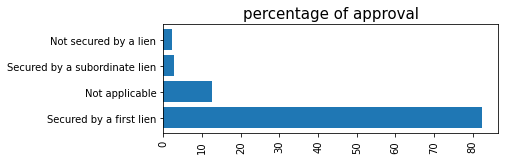

In [ ]:
value_counts_bar(lienCounts.toPandas(), 'percentage of approval','Lien Status')

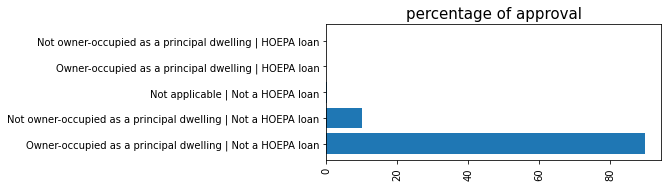

In [ ]:
value_counts_bar_twokeys(hownCounts.toPandas(),"percentage of approval","Owner Occupancy","Hoepa Status")

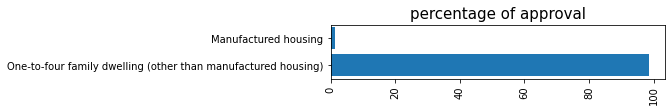

In [ ]:
value_counts_bar(propertyCounts.toPandas(), 'percentage of approval','Property Type for the Loan')

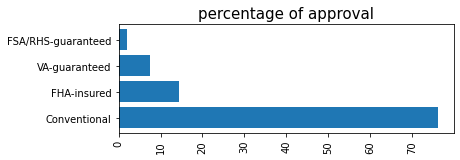

In [ ]:
value_counts_bar(typeCounts.toPandas(), 'percentage of approval','Loan Type')

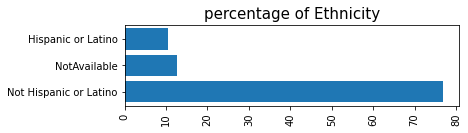

In [ ]:
value_counts_bar(ethTotalCounts.toPandas(), 'percentage of Ethnicity','Applicant''s Ethnicity')

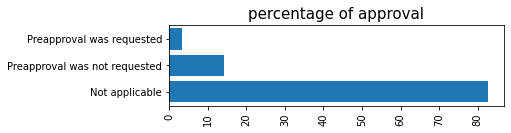

In [ ]:
value_counts_bar(preappCounts.toPandas(),"percentage of approval","Pre-approval name")

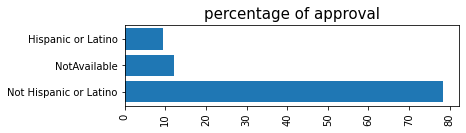

In [ ]:
value_counts_bar(ethCounts.toPandas(), 'percentage of approval','Applicant''s Ethnicity')

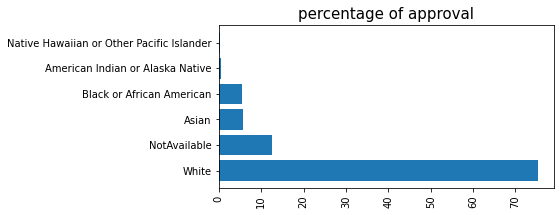

In [ ]:
value_counts_bar(raceCounts.toPandas(), 'percentage of approval','Applicant''s Race')

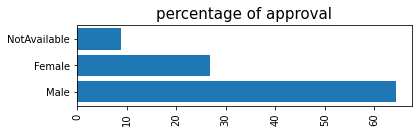

In [ ]:
value_counts_bar(genderCounts.toPandas(),"percentage of approval","Applicants Gender")

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(header=dict(values=["Loan State", 'Average Loan Amount', 'Average Income'],font=dict(size=20)),
                 cells=dict(values=[["Approval", "Denial"],
                                    [avgApproved_l.collect()[0][0], avgRejected_l.collect()[0][0]],
                                    [avgApproved_i.collect()[0][0], avgRejected_i.collect()[0][0]]],font=dict(size=14)))])
fig.show()

In [ ]:
minorityCounts

DataFrame[minority: bigint, Approval %: double]

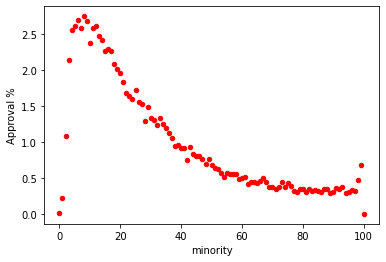

In [ ]:
minorityCounts.toPandas().plot(kind='scatter',x='minority',y='Approval %',color='red')
plt.show()

# **Machine Learning Model**

## **Decision Trees**

In [ ]:
# Import Spark SQL and Spark ML libraries
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
MaDF = rawData.select(col("agency_code").cast("float"),col("loan_type").cast("float"),col("property_type").cast("float"),col("loan_purpose").cast("float"),col("owner_occupancy").cast("float"),col("loan_amount_000s").cast("float"),col("preapproval").cast("float"),col("msamd").cast("float"),col("state_code").cast("float"),col("county_code").cast("float"),col("census_tract_number").cast("float"),col("applicant_ethnicity").cast("float"),col("co_applicant_ethnicity").cast("float"),col("applicant_race_1").cast("float"),col("co_applicant_race_1").cast("float"),col("applicant_sex").cast("float"),col("co_applicant_sex").cast("float"),col("applicant_income_000s").cast("float"),col("purchaser_type").cast("float"),col("hoepa_status").cast("float"),col("lien_status").cast("float"),col("population").cast("float"),col("minority_population").cast("float"),col("hud_median_family_income").cast("float"),col("tract_to_msamd_income").cast("float"),col("number_of_owner_occupied_units").cast("float"),col("number_of_1_to_4_family_units").cast("float"),col("application_date_indicator").cast("float"),col("action_taken").cast("float").alias("label"),col("action_taken_name"))

In [ ]:
#MaDF.select('action_taken_name').distinct().collect()

In [ ]:
MaDF = MaDF.filter((MaDF["action_taken_name"] != 'Application withdrawn by applicant') &(MaDF["action_taken_name"] != 'File closed for incompleteness'))

In [ ]:
MaDF.show(3)

+-----------+---------+-------------+------------+---------------+----------------+-----------+-------+----------+-----------+-------------------+-------------------+----------------------+----------------+-------------------+-------------+----------------+---------------------+--------------+------------+-----------+----------+-------------------+------------------------+---------------------+------------------------------+-----------------------------+--------------------------+-----+-----------------+
|agency_code|loan_type|property_type|loan_purpose|owner_occupancy|loan_amount_000s|preapproval|  msamd|state_code|county_code|census_tract_number|applicant_ethnicity|co_applicant_ethnicity|applicant_race_1|co_applicant_race_1|applicant_sex|co_applicant_sex|applicant_income_000s|purchaser_type|hoepa_status|lien_status|population|minority_population|hud_median_family_income|tract_to_msamd_income|number_of_owner_occupied_units|number_of_1_to_4_family_units|application_date_indicator|label

In [ ]:
MaDF = MaDF.withColumn('label',when((MaDF["label"] == 6)|(MaDF["label"] == 1),MaDF["label"]).otherwise(0))
MaDF = MaDF.withColumn('label',when((MaDF["label"] != 6),MaDF["label"]).otherwise(1))
MaDF.show(3)

+-----------+---------+-------------+------------+---------------+----------------+-----------+-------+----------+-----------+-------------------+-------------------+----------------------+----------------+-------------------+-------------+----------------+---------------------+--------------+------------+-----------+----------+-------------------+------------------------+---------------------+------------------------------+-----------------------------+--------------------------+-----+-----------------+
|agency_code|loan_type|property_type|loan_purpose|owner_occupancy|loan_amount_000s|preapproval|  msamd|state_code|county_code|census_tract_number|applicant_ethnicity|co_applicant_ethnicity|applicant_race_1|co_applicant_race_1|applicant_sex|co_applicant_sex|applicant_income_000s|purchaser_type|hoepa_status|lien_status|population|minority_population|hud_median_family_income|tract_to_msamd_income|number_of_owner_occupied_units|number_of_1_to_4_family_units|application_date_indicator|label

In [ ]:
#use one hot encoding on the categorical columns
'''
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["agency_code", "loan_type", "property_type","loan_purpose",
                                   "owner_occupancy","preapproval","applicant_ethnicity",
                                   "co_applicant_ethnicity", "applicant_race_1","co_applicant_race_1",
                                   "applicant_sex", "co_applicant_sex", "purchaser_type","hoepa_status",
                                   "lien_status"],
                        outputCols=["agency_code_vec", "loan_type_vec", "property_type_vec","loan_purpose_vec",
                                    "owner_occupancy_vec","preapproval_vec","applicant_ethnicity_vec",
                                    "co_applicant_ethnicity_vec", "applicant_race_1_vec","co_applicant_race_1_vec",
                                    "applicant_sex_vec","co_applicant_sex_vec","purchaser_type_vec","hoepa_status_vec",
                                    "lien_status_vec"])
MaDF = encoder.fit(MaDF).transform(MaDF)
'''
# Split the data
splits = MaDF.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1].withColumnRenamed("label", "trueLabel")
test.show()

+-----------+---------+-------------+------------+---------------+----------------+-----------+-------+----------+-----------+-------------------+-------------------+----------------------+----------------+-------------------+-------------+----------------+---------------------+--------------+------------+-----------+----------+-------------------+------------------------+---------------------+------------------------------+-----------------------------+--------------------------+---------+--------------------+
|agency_code|loan_type|property_type|loan_purpose|owner_occupancy|loan_amount_000s|preapproval|  msamd|state_code|county_code|census_tract_number|applicant_ethnicity|co_applicant_ethnicity|applicant_race_1|co_applicant_race_1|applicant_sex|co_applicant_sex|applicant_income_000s|purchaser_type|hoepa_status|lien_status|population|minority_population|hud_median_family_income|tract_to_msamd_income|number_of_owner_occupied_units|number_of_1_to_4_family_units|application_date_indicato

In [ ]:
vectorAssembler = VectorAssembler(inputCols = ["agency_code","loan_type", "property_type", "loan_purpose", "owner_occupancy","loan_amount_000s","preapproval","msamd","state_code","county_code","census_tract_number","applicant_ethnicity","co_applicant_ethnicity","applicant_race_1","co_applicant_race_1","applicant_sex","co_applicant_sex","applicant_income_000s","purchaser_type","hoepa_status","lien_status","population","minority_population","hud_median_family_income","tract_to_msamd_income","number_of_owner_occupied_units","number_of_1_to_4_family_units","application_date_indicator"],outputCol="features")
#Model1 - Decision Tree 
decision = DecisionTreeClassifier(labelCol="label", featuresCol= "features")
pipeline = Pipeline(stages=[vectorAssembler, decision])

In [ ]:
model = pipeline.fit(train)

In [ ]:
prediction = model.transform(test)
predicted = prediction.select("prediction", "trueLabel")

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(prediction)
print("Average Test Accuracy =", auc) 

Average Test Accuracy = 0.8502815726789176


In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
acc_training = evaluator.evaluate(model.transform(train))
print("Average Train Accuracy = ", acc_training)

Average Train Accuracy =  0.8504826200291331


In [ ]:
tp = float(predicted.filter("prediction == 1.0 AND truelabel == 1").count())
fp = float(predicted.filter("prediction == 1.0 AND truelabel == 0").count())
tn = float(predicted.filter("prediction == 0.0 AND truelabel == 0").count())
fn = float(predicted.filter("prediction == 0.0 AND truelabel == 1").count())
metrics = spark.createDataFrame([("Precision", tp / (tp + fp)), ("Recall", tp / (tp + fn))],["metric", "value"])
metrics.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|Precision|0.9303312116266479|
|   Recall|0.8997250998961217|
+---------+------------------+



## **Logistic Regression**

In [ ]:
assembler = VectorAssembler(inputCols = ["agency_code","loan_type", "property_type", "loan_purpose", "owner_occupancy","loan_amount_000s","preapproval","msamd","state_code","county_code","census_tract_number","applicant_ethnicity","co_applicant_ethnicity","applicant_race_1","co_applicant_race_1","applicant_sex","co_applicant_sex","applicant_income_000s","purchaser_type","hoepa_status","lien_status","population","minority_population","hud_median_family_income","tract_to_msamd_income","number_of_owner_occupied_units","number_of_1_to_4_family_units","application_date_indicator"], outputCol="features")
model = LogisticRegression(labelCol="label", featuresCol="features", maxIter=4, regParam=0.01)
pipeline = Pipeline(stages=[assembler,model])

In [ ]:
model = pipeline.fit(train)

In [ ]:
# list prediction
prediction = model.transform(test)
predicted = prediction.select("features", "prediction", "probability", "trueLabel")
predicted.show()

+--------------------+----------+--------------------+---------+
|            features|prediction|         probability|trueLabel|
+--------------------+----------+--------------------+---------+
|[1.0,1.0,1.0,1.0,...|       1.0|[0.06697731380445...|      1.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.07115411321217...|      1.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.14649890031743...|      1.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.26729177421420...|      0.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.02926479991480...|      1.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.06041516589486...|      1.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.18189808040045...|      1.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.37676953917222...|      0.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.00617175024943...|      1.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.14716066666565...|      1.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.43582114007079...|      1.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[0.12736012221248...|      1.0|
|[1.0,1.0,1.0,1.0,...|   

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(prediction)
print("AUC Test = ", auc)

AUC Test =  0.6344621062656983


In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
acc_training = evaluator.evaluate(model.transform(train))
print("Average Train Accuracy = ", acc_training)

Average Train Accuracy =  0.6348270507222835


## **Naive Bayes**

In [ ]:
from pyspark.ml.classification import NaiveBayes
assembler = VectorAssembler(inputCols = ["agency_code","loan_type", "property_type", "loan_purpose", "owner_occupancy","loan_amount_000s","preapproval","msamd","state_code","county_code","census_tract_number","applicant_ethnicity","co_applicant_ethnicity","applicant_race_1","co_applicant_race_1","applicant_sex","co_applicant_sex","applicant_income_000s","purchaser_type","hoepa_status","lien_status","population","minority_population","hud_median_family_income","tract_to_msamd_income","number_of_owner_occupied_units","number_of_1_to_4_family_units","application_date_indicator"], outputCol="features")
model = NaiveBayes(smoothing=1.0, modelType="multinomial")
pipeline = Pipeline(stages=[assembler,model])

In [ ]:
model = pipeline.fit(train)

In [ ]:
# list prediction
prediction = model.transform(test)
predicted = prediction.select("features", "prediction", "probability", "trueLabel")
predicted.show(5)

+--------------------+----------+--------------------+---------+
|            features|prediction|         probability|trueLabel|
+--------------------+----------+--------------------+---------+
|[1.0,1.0,1.0,1.0,...|       1.0|[6.95912099720099...|      1.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[2.68208818303639...|      1.0|
|[1.0,1.0,1.0,1.0,...|       0.0|[1.0,2.8026390424...|      1.0|
|[1.0,1.0,1.0,1.0,...|       0.0|[1.0,1.3774413790...|      0.0|
|[1.0,1.0,1.0,1.0,...|       1.0|[1.07460451844898...|      1.0|
+--------------------+----------+--------------------+---------+
only showing top 5 rows



In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(prediction)
print("AUC Test = ", auc)

AUC Test =  0.5688206243272074


In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
acc_training = evaluator.evaluate(model.transform(train))
print("Average Train Accuracy = ", acc_training)

Average Train Accuracy =  0.5681886426106131


##**Recommendation**



In [ ]:
#takes random Sample
sample = rawData.sample(False, 0.5,seed = 20).limit(1)
#sample = rawData.rdd.takeSample(False, 1, seed=0)
sample.show()

+---+-------------+--------------------+-----------+-----------+--------------+---------+--------------------+-------------+-----------------+------------+--------------------+---------------+----------------+----------------+-----------+-----------------+------------+----------+-------+----------+----------+----------+-----------+-----------+-------------------+------------------------+-------------------+---------------------------+----------------------+---------------------+----------------+------------------------+-------------------+------------------+-------------+---------------------+----------------+---------------------+--------------------+--------------+-----------------+------------+--------------------+-----------+---------------+----------+-------------------+------------------------+---------------------+------------------------------+-----------------------------+--------------------------+
|_c0|respondent_id|         agency_name|agency_abbr|agency_code|loan_type_name

In [ ]:
#def getrows(df, rownums=None):
    #return df.rdd.zipWithIndex().filter(lambda x: x[1] in rownums).map(lambda x: x[0])
#onesample = getrows(sample, rownums=[7]).collect()

In [ ]:
#resampling to fit model
resample = sample.select(col("agency_code").cast("float"),col("loan_type").cast("float"),col("property_type").cast("float"),col("loan_purpose").cast("float"),col("owner_occupancy").cast("float"),col("loan_amount_000s").cast("float"),col("preapproval").cast("float"),col("msamd").cast("float"),col("state_code").cast("float"),col("county_code").cast("float"),col("census_tract_number").cast("float"),col("applicant_ethnicity").cast("float"),col("co_applicant_ethnicity").cast("float"),col("applicant_race_1").cast("float"),col("co_applicant_race_1").cast("float"),col("applicant_sex").cast("float"),col("co_applicant_sex").cast("float"),col("applicant_income_000s").cast("float"),col("purchaser_type").cast("float"),col("hoepa_status").cast("float"),col("lien_status").cast("float"),col("population").cast("float"),col("minority_population").cast("float"),col("hud_median_family_income").cast("float"),col("tract_to_msamd_income").cast("float"),col("number_of_owner_occupied_units").cast("float"),col("number_of_1_to_4_family_units").cast("float"),col("application_date_indicator").cast("float"))
resample.show()

+-----------+---------+-------------+------------+---------------+----------------+-----------+-------+----------+-----------+-------------------+-------------------+----------------------+----------------+-------------------+-------------+----------------+---------------------+--------------+------------+-----------+----------+-------------------+------------------------+---------------------+------------------------------+-----------------------------+--------------------------+
|agency_code|loan_type|property_type|loan_purpose|owner_occupancy|loan_amount_000s|preapproval|  msamd|state_code|county_code|census_tract_number|applicant_ethnicity|co_applicant_ethnicity|applicant_race_1|co_applicant_race_1|applicant_sex|co_applicant_sex|applicant_income_000s|purchaser_type|hoepa_status|lien_status|population|minority_population|hud_median_family_income|tract_to_msamd_income|number_of_owner_occupied_units|number_of_1_to_4_family_units|application_date_indicator|
+-----------+---------+-----

In [ ]:
avgincome_d = dict(zip(list(df_avg_income.select('msamd').toPandas()['msamd']), list(df_avg_income.select('avg(income)').toPandas()['avg(income)'])))

In [ ]:
avgfamilyincome_d = dict(zip(list(df_avg_family_income.select('msamd').toPandas()['msamd']), list(df_avg_family_income.select('avg(family_income)').toPandas()['avg(family_income)'])))

In [ ]:
avgloan_d = dict(zip(list(df_avg_loan.select('msamd').toPandas()['msamd']), list(df_avg_loan.select('avg(loan_amount)').toPandas()['avg(loan_amount)'])))

In [ ]:
model.transform(resample).collect()[0]['prediction']

1.0

In [ ]:
#buy in another place pre approval - income and loan
def recommend(sample,model):
  samplelist = sample.collect()[0]
  re_sample = sample.select(col("agency_code").cast("float"),col("loan_type").cast("float"),col("property_type").cast("float"),col("loan_purpose").cast("float"),col("owner_occupancy").cast("float"),col("loan_amount_000s").cast("float"),col("preapproval").cast("float"),col("msamd").cast("float"),col("state_code").cast("float"),col("county_code").cast("float"),col("census_tract_number").cast("float"),col("applicant_ethnicity").cast("float"),col("co_applicant_ethnicity").cast("float"),col("applicant_race_1").cast("float"),col("co_applicant_race_1").cast("float"),col("applicant_sex").cast("float"),col("co_applicant_sex").cast("float"),col("applicant_income_000s").cast("float"),col("purchaser_type").cast("float"),col("hoepa_status").cast("float"),col("lien_status").cast("float"),col("population").cast("float"),col("minority_population").cast("float"),col("hud_median_family_income").cast("float"),col("tract_to_msamd_income").cast("float"),col("number_of_owner_occupied_units").cast("float"),col("number_of_1_to_4_family_units").cast("float"),col("application_date_indicator").cast("float"))
  result = model.transform(re_sample).collect()[0]['prediction']

  if result == 1:
    result = 'Loan accepted !'
  else:
    result = 'Loan rejected !'
  print(result)

  if result == 'Loan rejected !':
    agency = samplelist['agency_name']
    preaprroval = samplelist['preapproval_name']
    income = samplelist['applicant_income_000s']
    familyincome = samplelist['hud_median_family_income']
    loan = samplelist['loan_amount_000s']
    msamd = samplelist['msamd']
    if agency != 'Department of Housing and Urban Development':
      print('you should ask for your loan from Department of Housing and Urban Development !')
    if preaprroval != 'Preapproval was not requested':
      print("you shouldn't apply with preapproval documents !")
    if (float(income) < avgincome_d['msamd'] - 20):
      print("you should have at least income of {}k !".format(str(avgincome_d['msamd'] - 20)))
    if (float(loan) > avgloan_d['msamd'] + 20):
      print("you should apply for a loan that not exceed {}k !".format(str(avgloan_d['msamd'] + 20)))
    if (float(income) < avgfamilyincome_d['msamd']/1000):
      print("your should have at least income of {}k to suit with locals !".format(str(avgfamilyincome_d['msamd']/1000 - 20)))


In [ ]:
recommend(sample,model)

Loan accepted !
